In [7]:
import numpy as np
# Symbol | Meaning
# n_v  : Number of Visibilities
# n_g  : Grid_size 
# n_s  : Support(Kernel) Size
# n_sg : Sub-Grid Size (W-Towers)
# n_c  : Number of Chunks (W-Towers)
# n_f  : Number of Floors (W-Towers, W-Stacking)

def calculate_support_size(w_val, field_of_view, n):

    e1 = (w_val * field_of_view)/2
    e2 = np.sqrt(w_val)
    e3 = (np.pi * n)/e2
    
    return np.ceil(np.sqrt(np.square(e1) + e1/e3))


## Grid Complexity
def flops_grid(n_v, n_s):
    return 6 * n_v * np.square(n_s)
    
## Fourier Transform Complexity
def flops_ft_wtowers(n_g, n_sg, n_c, n_f):
    subgrid_ft_flops = 5 * n_c * n_f * np.square(n_sg) * np.log2(np.square(n_sg))
    grid_ft_flops = 5 * np.square(n_g) * np.log2(np.square(n_g))
    return subgrid_ft_flops + grid_ft_flops
    
def flops_ft_wstack(n_g, n_f):
    return 5 * np.square(n_g) * np.log2(np.square(n_g)) * n_f

def flops_ft_wproj(n_g):
    return 5 * np.square(n_g) * np.log2(np.square(n_g))
    
## W-Correction Complexity
def flops_wc_wtowers(n_sg, n_c, n_f):
    return 6 * n_c * n_f * np.square(n_sg)

def flops_wc_wstack(n_g, n_f):
    return 6 * n_f * np.square(n_g)

## W-Transfer Complexity
def flops_wt_wtowers(n_sg,n_c):
    return 18 * n_c * np.square(n_sg)

## Reduction Complexity
def flops_reduc_wtowers(n_sg, n_c):
    return 2 * n_c * np.square(n_sg)

def flops_reduc_wstack(n_g, n_f):
    return 2 * n_f * np.square(n_g)

## Tying it all together

def calculate_flops_wtowers(n_v, n_g, n_s, n_sg, n_c, n_f):
    return (flops_grid(n_v,n_s) + flops_ft_wtowers(n_g, n_sg, n_c, n_f)) #+ 
            #flops_wc_wtowers(n_sg, n_c, n_f) + flops_wt_wtowers(n_sg, n_c) +
           #flops_reduc_wtowers(n_sg, n_c))

def calculate_flops_wstacking(n_v, n_g, n_s, n_c, n_f):  
    return (flops_grid(n_v,n_s) + flops_ft_wstack(n_g, n_f) + flops_wc_wstack(n_g, n_f)
            + flops_reduc_wstack(n_g, n_f))
    
    
def calculate_flops_wproj(n_v, n_g, n_s):
    return (flops_grid(n_v, n_s) + flops_ft_wproj(n_g))

#Useful later
vflopstower = np.vectorize(calculate_flops_wtowers)
vflopsstack = np.vectorize(calculate_flops_wstacking)
vflopsproj = np.vectorize(calculate_flops_wproj)

# Artifical Test Case. 
## Allows us to see how they compare head to head.
W-Projection is the clear winner, but it is nigh impossible to parallelise. Low total flops, high barrier to effective parallelisation. Also we do not calculate complexity of variable w-kernels here, which would prove more comparable (should do this in future).

W-Stacking and W-Towers almost identical, marginally higher flops(5-8%) for W-Towers. 

- W-Projection: Total FLOPS lowest, nightmare to parallelise.
- W-Stacking: Excellent parallelisation opportunity along the w-axis
- W-Towers: Even better parallelisation opportunity via u-v, due to locality benefits. Better total flops and complexity scales better for different parameters.

I contend that W-Towers is a great alternative due to its strong focus on parallelisation combined with strong locality, without increasing total flop count much over W-Stacking. Indeed, it pushes the complexity into a form that is more amenable to efficient computation. Where efficiency is making an image both quickly and accurately, with minimal energy expenditure. 

Scaling needs to be explored.

In [14]:
def calculate_chunks(grid_size,subgrid_size, support_size):
    chunk_size = subgrid_size - support_size
    chunk_count_1d = np.floor(grid_size / chunk_size +1)
    return np.square(chunk_count_1d)

vis_no = 10000000000
grid_size = 2048
w_tot = 4000
n_floors = 400
w_inc = w_tot / n_floors

support_size_stack = calculate_support_size(w_inc, 0.1, 0.01) # FoV of 0.1 radians, and truncate w-kernel at 0.01
support_size_wproj = calculate_support_size(w_tot, 0.1, 0.01)

print("Support Sizes: ")
print("W-Projection: %d" % support_size_wproj)
print("W-Stacking: %d" % support_size_stack)


support_size = 16
margin_size = np.floor((support_size + 1)/2)
subgrid_size = 256

chunks = calculate_chunks(grid_size, subgrid_size, support_size_stack) #Halo Management necessitates more chunks
print("W-Towers chunk count: %d" % chunks)


print("W-Towers FLOP Count     : %d" % calculate_flops_wtowers(vis_no, grid_size, support_size_stack, subgrid_size, chunks, n_floors))
print("W-Stacking FLOP Count   : %d" % calculate_flops_wstacking(vis_no, grid_size, support_size_stack, chunks, n_floors))
print("W-Projection Flop Count : %d" % calculate_flops_wproj(vis_no, grid_size, support_size_wproj))

Support Sizes: 
W-Projection: 666
W-Stacking: 8
W-Towers chunk count: 81
W-Towers FLOP Count     : 4010330685440
W-Stacking FLOP Count   : 4037971148800
W-Projection Flop Count : 26613360461373440


# FLOP Scaling as Function of Subgrid Size (W-Towers)

It can be seem from the graph below that W-Towers incurs less floating point cost than W-Stacking for certain subgrid sizes. Where the subgrid size is more than $\frac{Grid Size}{2}$ , W-Towers essentially becomes a much less efficient version of W-Stacking. In this regime, it's better to switch to W-Stacking proper.

W-Towers is also very parameter dependent due to the number of chunks calculation. Note the uneven second-order response. However for small subgrid sizes $Sub Size < \frac{Grid Size}{4} $

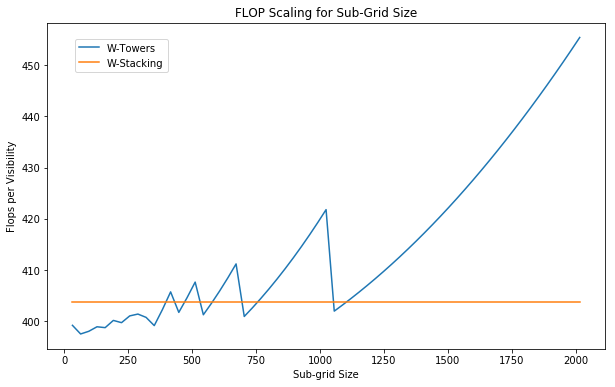

In [19]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 6)

##So jupyter renders properly on my dark emacs background..
mpl.rcParams['figure.facecolor'] = "white"


def plot_flops_for_increase_subgrid(max_sg, min_sg, sg_iter,
                                   vis_no, grid_size, support_size, floors):
    arr_sg_size = np.arange(min_sg,max_sg,sg_iter,dtype=int)
    vchunk = np.vectorize(calculate_chunks)
    chunk_count =  vchunk(grid_size, arr_sg_size, support_size_stack)
    #print(chunk_count)
    
    flop_counts = vflopstower(vis_no, grid_size, support_size, arr_sg_size, chunk_count, floors)
    #print(arr_sg_size)
    #print(flop_counts)
    
    #Just gets it into a format we can plot.
    flop_wstack = vflopsstack(vis_no, grid_size, support_size, chunk_count, floors)  
    plt.plot(arr_sg_size,flop_counts/vis_no,label='W-Towers')
    plt.plot(arr_sg_size,flop_wstack/vis_no,label='W-Stacking')
    plt.xlabel('Sub-grid Size')
    plt.ylabel('Flops per Visibility')
    plt.title("FLOP Scaling for Sub-Grid Size")
    plt.legend(bbox_to_anchor=(0.05, 0.95), loc=2, borderaxespad=0.)
    plt.savefig("wtowerstack_scale.pdf")
    plt.show()
 

plot_flops_for_increase_subgrid(2048, 32,32, vis_no, grid_size, support_size_stack, n_floors)

# FFT Scaling

We can see that this oscillation with $Period \propto N^2 $ is a result of the FFT cost in W-Towers. ~~This is because of the way in which chunks are being aligned across margins/halos (I think)~~ ~~Not right on all counts!~~

Nope am right. It's because of how many chunks cover the grid at any one time. If they are a poor fit, then the worst case could be a very large grid for that amount of chunks. One can safely decrease subgrid size to a point whilst still allowing full coverage with that chunk_count. Hence the spiky nature!



Margin Size: 8.000000


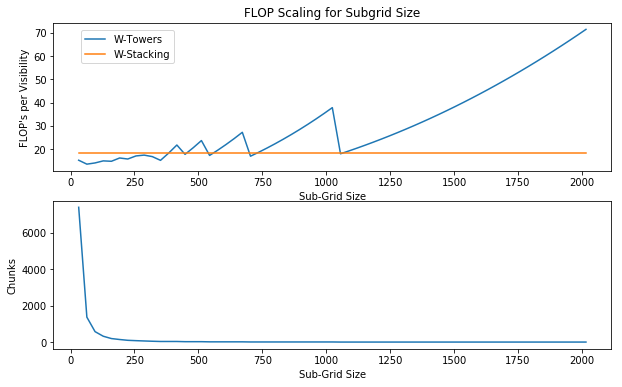

In [18]:
def _flops_ft_towers_m(grid_size, subgrid_size, margin_size, floors):
    
    chunk_count = calculate_chunks(grid_size, subgrid_size,margin_size)
#    print("Chunks: {}, Subgrid Size: {}, Grid Size: {}, Floors: {}".format(chunk_count,subgrid_size, grid_size, floors))
#    print(flops_ft_wtowers(grid_size, subgrid_size, chunk_count, floors))
    return flops_ft_wtowers(grid_size, subgrid_size, chunk_count, floors)


def plot_flopsfft_for_increase_subgrid(max_sg, min_sg, sg_iter,
                                      vis_no, grid_size, support_size, floors):
    
    arr_sg_size = np.arange(min_sg,max_sg,sg_iter,dtype=int)
    print("Margin Size: %f" % margin_size)
    vchunk = np.vectorize(calculate_chunks)
    chunk_count =  vchunk(grid_size, arr_sg_size, support_size)
    
    vffttowers = np.vectorize(_flops_ft_towers_m)
    vfftstack = np.vectorize(flops_ft_wstack)
    
    flops_towers = vffttowers(grid_size, arr_sg_size, support_size, floors)
    flops_stack = np.full(flops_towers.size, flops_ft_wstack(grid_size, floors))
#    print(arr_sg_size)
#    print(flops_towers)
    fig, ax = plt.subplots(nrows=1, ncols=2)
    plt.subplot(211)
    plt.xlabel("Sub-Grid Size")
    plt.ylabel("FLOP's per Visibility")
    plt.plot(arr_sg_size,flops_towers/vis_no, label="W-Towers")
    plt.plot(arr_sg_size,flops_stack/vis_no, label="W-Stacking")
    plt.title("FLOP Scaling for Subgrid Size")
    plt.legend(bbox_to_anchor=(0.05, 0.95), loc=2, borderaxespad=0.)
    plt.subplot(212)
    plt.xlabel("Sub-Grid Size")
    plt.ylabel("Chunks")
    plt.plot(arr_sg_size,chunk_count)
    plt.savefig("subgrid_scaling.pdf")
    plt.show()
    

plot_flopsfft_for_increase_subgrid(2048, 32, 32, vis_no, grid_size, support_size_stack, n_floors)

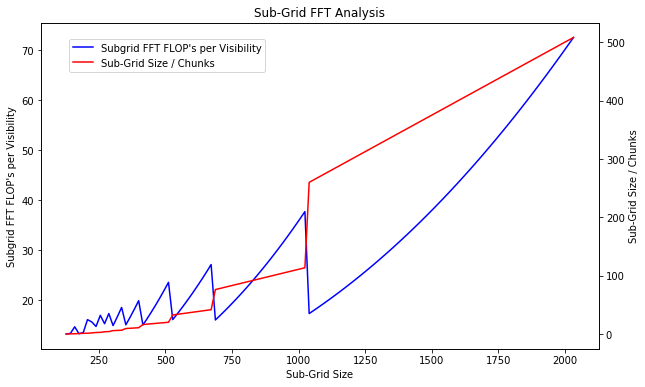

In [20]:
def wtowers_ft_sub(subg,count,floors):
    return 5 * count * floors * np.square(subg) * np.log2(np.square(subg))

def wtowers_ft_grid(grid_size):
    return 5 * np.square(grid_size) * np.log2(np.square(subg))

def plot_fft_complexity_components_towers(max_sg, min_sg, sg_iter,
                                         vis_no, grid_size, support_size, floors):
    
    sg_arr = np.arange(min_sg, max_sg, sg_iter, dtype=int)
    margin = np.floor((support_size + 1)/2)
    vchunk = np.vectorize(calculate_chunks)
    chunk_arr = vchunk(grid_size, sg_arr, margin)
    
    vwtowers_ft_sub = np.vectorize(wtowers_ft_sub)
    vwtowers_ft_grid = np.vectorize(wtowers_ft_grid)
    
    fft_sub = vwtowers_ft_sub(sg_arr,chunk_arr, floors)

    fig, ax1 = plt.subplots()
    ln1 = ax1.plot(sg_arr, fft_sub/vis_no,'b-',label="Subgrid FFT FLOP's per Visibility")
    ax1.set_xlabel("Sub-Grid Size")
    ax1.set_ylabel("Subgrid FFT FLOP's per Visibility")
    ax2 = ax1.twinx()
    ax2.set_ylabel("Sub-Grid Size / Chunks")
    ln2 = ax2.plot(sg_arr, sg_arr / chunk_arr,'r-',label='Sub-Grid Size / Chunks')
    lns = ln1 + ln2
    labs = [l.get_label() for l in lns]
    
    ax1.legend(lns,labs,bbox_to_anchor=(0.05, 0.95), loc=2, borderaxespad=0.)
    plt.title("Sub-Grid FFT Analysis")
    plt.savefig("fft_scale.pdf")
    plt.show()
    
plot_fft_complexity_components_towers(2048, 128, 16, vis_no, grid_size, support_size_stack, n_floors)



# FLOP Scaling as a function of Floor Count

As W Increases(necessitating more floors), then W-Towers scales better due to the FFT advantage (if ran with a good subgrid size as selected from previous result)


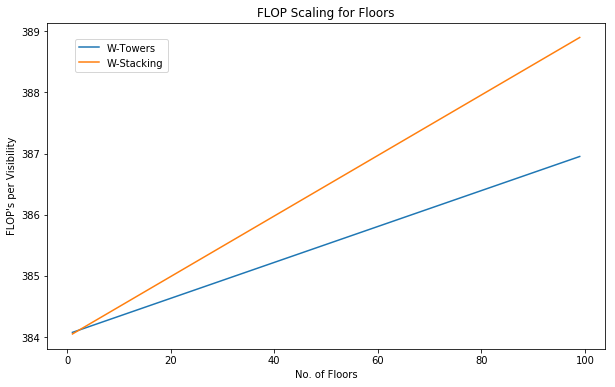

In [23]:
def plot_flops_for_increase_floors(min_floor, max_floor, floor_iter,
                                  vis_no, grid_size, support_size, subgrid_size):
    
    arr_floors = np.arange(min_floor, max_floor, floor_iter)
    margin_size = np.floor((support_size +1)/2)
    chunk_count = calculate_chunks(grid_size,margin_size ,subgrid_size)
    
    flops_towers = vflopstower(vis_no, grid_size, support_size, subgrid_size, chunk_count, arr_floors)
    flops_wstack = vflopsstack(vis_no, grid_size, support_size, chunk_count, arr_floors)
    
    plt.plot(arr_floors,flops_towers/vis_no, label = "W-Towers")
    plt.plot(arr_floors,flops_wstack/vis_no, label = "W-Stacking")
    plt.xlabel("No. of Floors")
    plt.ylabel("FLOP's per Visibility")
    plt.title("FLOP Scaling for Floors")
    plt.legend(bbox_to_anchor=(0.05, 0.95), loc=2, borderaxespad=0.)
    plt.savefig("floors_scaling.pdf")
    plt.show()

    
plot_flops_for_increase_floors(1, 100, 1, vis_no, grid_size, support_size_stack, 128)

# Visibility Scaling

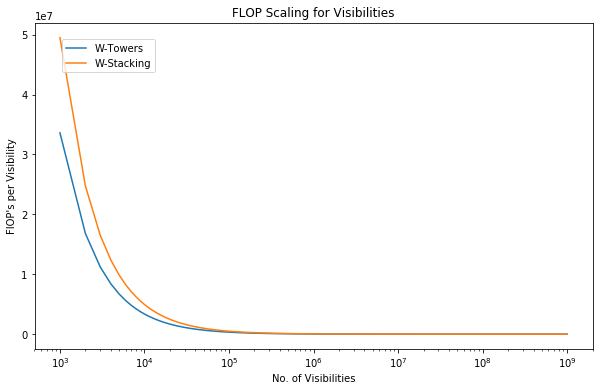

In [ ]:
def plot_flops_for_increase_vis(min_vis, max_vis, vis_iter,
                                subgrid_size, grid_size, support_size, floors):

    arr_vis = np.arange(min_vis, max_vis, vis_iter)
    margin_size = np.floor((support_size + 1)/2)

    chunk_count = calculate_chunks(grid_size, margin_size, subgrid_size)

    flops_towers = vflopstower(arr_vis, grid_size, support_size, subgrid_size, chunk_count, floors) / arr_vis
    flops_wstack = vflopsstack(arr_vis, grid_size, support_size, chunk_count, floors) / arr_vis
    
    
    plt.plot(arr_vis, flops_towers, label='W-Towers')
    plt.plot(arr_vis, flops_wstack, label='W-Stacking')
    plt.xlabel('No. of Visibilities')
    plt.xscale('log')
    plt.ylabel('FlOP\'s per Visibility')
    plt.yscale('log')
    plt.title('FLOP Scaling for Visibilities') 
    plt.legend(bbox_to_anchor=(0.05, 0.95), loc=2, borderaxespad=0.)
    plt.savefig("visibility_scaling.pdf")
    plt.show()
    
plot_flops_for_increase_vis(1000,1e9,1000,128, grid_size, support_size, 100)
    